# Hyderabad House Price Pre-procesing

In [2]:
import pandas as pd

PRICE = "Price"
LOCATION = "Location"
REFRIGERATOR = "Refrigerator"
SECURITY = "24X7Security"
AREA = "Area"
BED_ROOMS = "No. of Bedrooms"

house_prices_ds = pd.read_csv('../../../datasets/raw/hyderabad_house_price_with_nullables.csv')
labels_ds = house_prices_ds[PRICE]
features_ds = house_prices_ds.drop(columns=[PRICE])
numeric_features_df = features_ds.select_dtypes(include=["int64", "float64"])
categorical_features_df = features_ds[LOCATION]
processed_ds = None

def convertArrayToDataset(dataset):
    return pd.DataFrame(
    dataset,
    columns=dataset.columns,
    index=dataset.index)

def exportDataset(dataset, step):
    dataset.to_csv(f"../../../datasets/processed/hyderabad_house_price_{step}.csv")

## 1.0 Missing Values

Replacing missing numerical values with the most frequent values (mode).

In [3]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class WindowImputer(BaseEstimator, TransformerMixin):
    """
    Imputa Column usando vecinos con Label column en [Label - window, Label + window].
    Si no hay vecinos, expande la ventana (x2) hasta max_expansions veces.
    Fallback: mediana global de AREA.
    """
    def __init__(self, column="Area", label_col="Price", window=1000.0,
                 agg="median", expand=True, max_expansions=2):
        self.column = column
        self.label_col = label_col
        self.window = float(window)
        self.agg = agg
        self.expand = expand
        self.max_expansions = int(max_expansions)

    def fit(self, X, y=None):
        df = X.copy()
        df[self.label_col] = pd.to_numeric(df[self.label_col], errors="coerce")
        df[self.column]  = pd.to_numeric(df[self.column],  errors="coerce")
        self._train_ = df[[self.label_col, self.column]].copy()

        if self.agg == "mean":
            self._aggfunc_ = np.nanmean
        else:
            self._aggfunc_ = np.nanmedian

        self.global_fallback_ = float(self._aggfunc_(self._train_[self.column].values))
        return self

    def transform(self, X):
        df = X.copy()
        df[self.label_col] = pd.to_numeric(df[self.label_col], errors="coerce")
        df[self.column]  = pd.to_numeric(df[self.column],  errors="coerce")

        na_idx = df[self.column].isna()
        if not na_idx.any():
            return df

        for idx, p in df.loc[na_idx, self.label_col].items():
            # Si no hay Price para esta fila, fallback global.
            if pd.isna(p):
                df.at[idx, self.column] = self.global_fallback_
                continue

            w = self.window
            imputed = None
            for _ in range(self.max_expansions + 1):
                low, high = p - w, p + w
                mask = (
                    self._train_[self.label_col].between(low, high)
                    & self._train_[self.column].notna()
                )
                candidates = self._train_.loc[mask, self.column]
                if len(candidates):
                    imputed = float(self._aggfunc_(candidates.values))
                    break
                if not self.expand:
                    break
                w *= 2  # expandimos la ventana

            if imputed is None:
                imputed = self.global_fallback_
            df.at[idx, self.column] = imputed

        return df
    


In [4]:
from sklearn.impute import SimpleImputer

df = house_prices_ds.copy()

# Impute the REFRIGERATOR and SECURITY with the most frequent value
mf_imputer = SimpleImputer(strategy="most_frequent")
mf_cols = [REFRIGERATOR, SECURITY]
df[mf_cols] = mf_imputer.fit_transform(df[mf_cols])

# Impute Area with the Custom Window Imputer
area_imputer = WindowImputer(column=AREA, label_col=PRICE, window=1000, agg="median")
df = area_imputer.fit_transform(df)

# Impute Bed rooms with the Custom Window Imputer
bed_imputer = WindowImputer(column=BED_ROOMS, label_col=PRICE, window=1000, agg="median")
imputed_features_df = bed_imputer.fit_transform(df)

# Write processed dataset
processed_ds = convertArrayToDataset(imputed_features_df)
exportDataset(processed_ds, "1_nullables")

print("Total Missing values:", processed_ds.isna().sum().sum())
processed_ds.isnull().sum()


Total Missing values: 0


Price                  0
Area                   0
Location               0
No. of Bedrooms        0
Resale                 0
MaintenanceStaff       0
Gymnasium              0
SwimmingPool           0
LandscapedGardens      0
JoggingTrack           0
RainWaterHarvesting    0
IndoorGames            0
ShoppingMall           0
Intercom               0
SportsFacility         0
ATM                    0
ClubHouse              0
School                 0
24X7Security           0
PowerBackup            0
CarParking             0
StaffQuarter           0
Cafeteria              0
MultipurposeRoom       0
Hospital               0
WashingMachine         0
Gasconnection          0
AC                     0
Wifi                   0
Children'splayarea     0
LiftAvailable          0
BED                    0
VaastuCompliant        0
Microwave              0
GolfCourse             0
TV                     0
DiningTable            0
Sofa                   0
Wardrobe               0
Refrigerator           0


## 2.0 Transform Categorical Data

Convert categorical features to Dummy variables

In [6]:
## Transform Categorical Data
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = house_prices_ds.copy()

# Create encoder
encoder = OneHotEncoder(sparse_output=True, drop=None, handle_unknown="ignore")

# Set and transform Location
location_encoded = encoder.fit_transform(df[["Location"]])


# Alternative: use dummy variables when there are few categories 
# house_prices_ds_encoded = pd.get_dummies(processed_ds, columns=["Location"])

categorical_features_df = pd.DataFrame(
    location_encoded.toarray(),
    columns=encoder.get_feature_names_out([LOCATION]),
    index=house_prices_ds.index
)


processed_ds = pd.concat(
    [processed_ds.drop(columns=[LOCATION]), categorical_features_df],
    axis=1
)

exportDataset(processed_ds, "2_categorical")

processed_ds.head()



,Price,Area,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,...,Location_Zamistanpur,Location_chandrayangutta,Location_financial District,Location_hyderabad,Location_manneguda,Location_muthangi,Location_new nallakunta,Location_nizampet road,Location_raidurgam,Location_west venkatapuram
0,6968000,1340.0,2.0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29000000,3498.0,4.0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6590000,1318.0,2.0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5739000,1295.0,3.0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5679000,1145.0,2.0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.0 Fix Outiers values


In [7]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class BinaryRangeImputer(BaseEstimator, TransformerMixin):
    """
    Reemplaza valores fuera de [0,1] en columnas binarias por el valor más frecuente de esa columna.
    """
    def __init__(self, columns=None, valid_range=(0,1)):
        self.columns = columns
        self.valid_range = valid_range
        self.fill_values_ = {}

    def fit(self, X, y=None):
        df = X.copy()
        for col in self.columns:
            # valores válidos
            mask_valid = df[col].between(self.valid_range[0], self.valid_range[1])
            mode_val = df.loc[mask_valid, col].mode(dropna=True)
            # fallback: si no hay válidos, usa 0
            self.fill_values_[col] = mode_val.iloc[0] if not mode_val.empty else 0
        return self

    def transform(self, X):
        df = X.copy()
        for col in self.columns:
            mask_invalid = ~df[col].between(self.valid_range[0], self.valid_range[1])
            df.loc[mask_invalid, col] = self.fill_values_[col]
        return df


In [8]:
binary_cols = ["MaintenanceStaff", "Gymnasium","SwimmingPool","LandscapedGardens","JoggingTrack","RainWaterHarvesting",
        "IndoorGames","ShoppingMall","Intercom","SportsFacility","ATM","ClubHouse","School",
        "24X7Security","PowerBackup","CarParking","StaffQuarter","Cafeteria","MultipurposeRoom",
        "Hospital","WashingMachine","Gasconnection","AC","Wifi","Children'splayarea",
        "LiftAvailable","BED","VaastuCompliant","Microwave","GolfCourse","TV","DiningTable",
        "Sofa","Wardrobe","Refrigerator"]


mask_invalid_before = (processed_ds[binary_cols] < 0) | (processed_ds[binary_cols] > 1)
rows_invalid_before = processed_ds[mask_invalid_before.any(axis=1)]
print("Invalid binary features before:", len(rows_invalid_before[binary_cols]))

# 1. Transform invalid binary values by most frecuent
imputer = BinaryRangeImputer(columns=binary_cols, valid_range=(0,1))
binary_impute = imputer.fit_transform(processed_ds)
exportDataset(processed_ds, "3_outiers")

mask_invalid_after = (binary_impute[binary_cols] < 0) | (binary_impute[binary_cols] > 1)
rows_invalid_after = binary_impute[mask_invalid_after.any(axis=1)]
print("Invalid binary features after:", len(rows_invalid_after[binary_cols]))


Invalid binary features before: 88
Invalid binary features after: 0


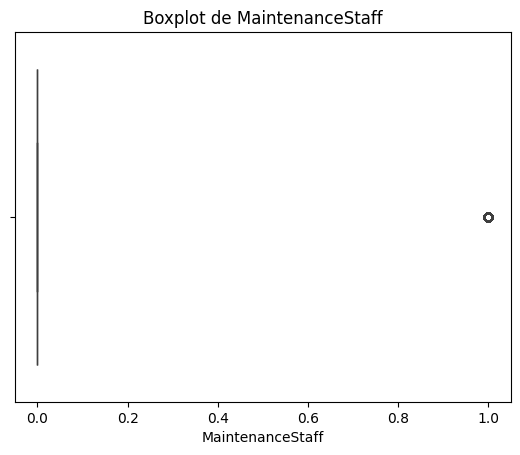

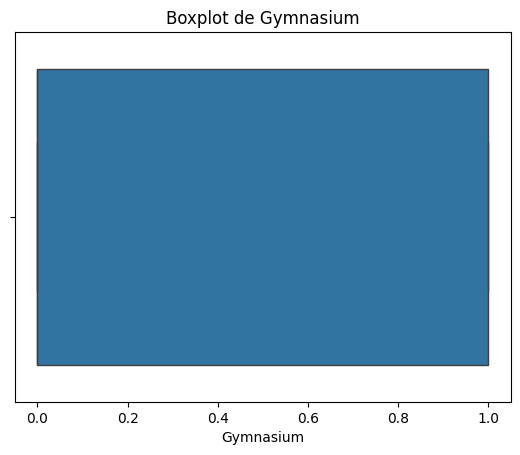

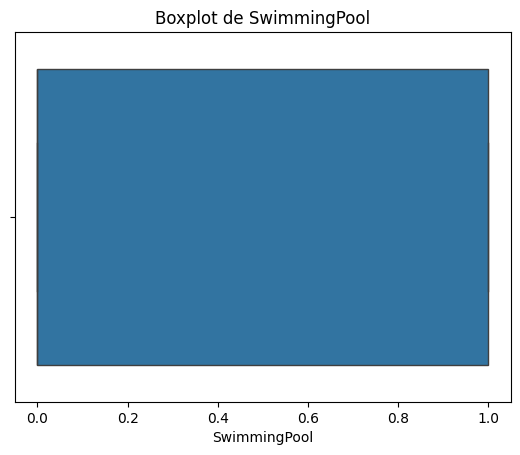

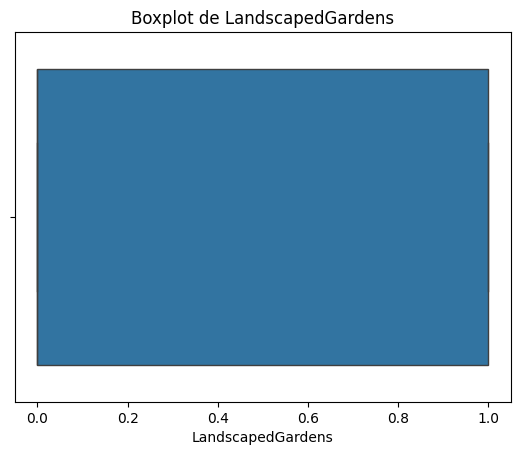

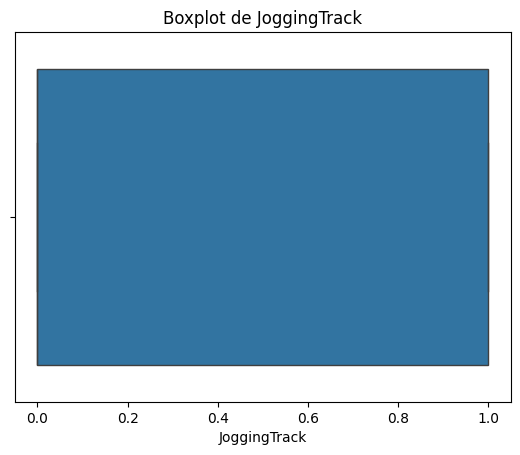

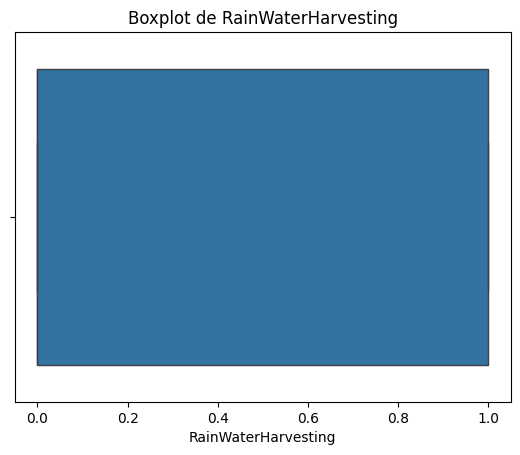

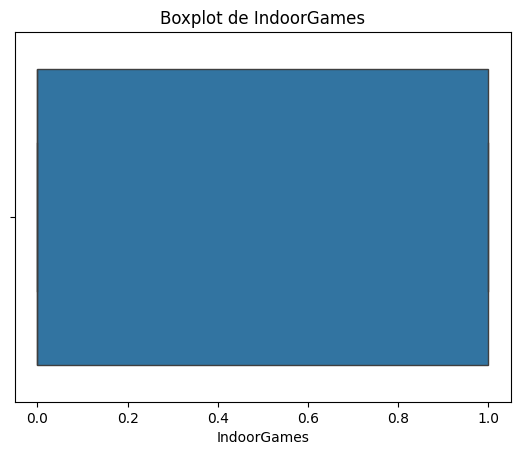

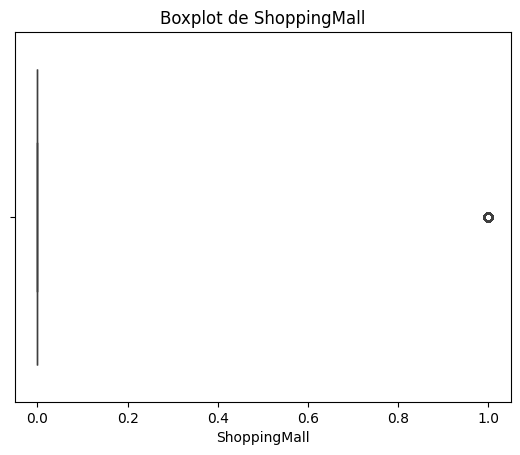

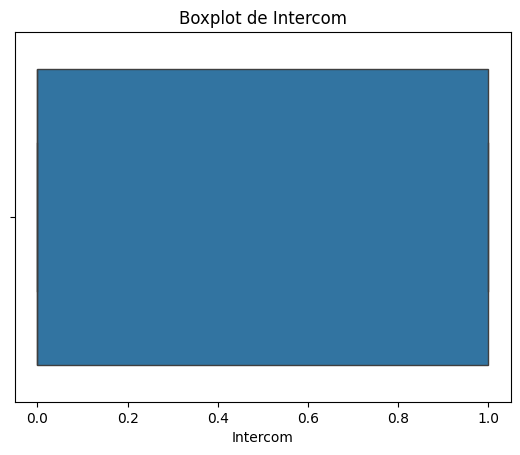

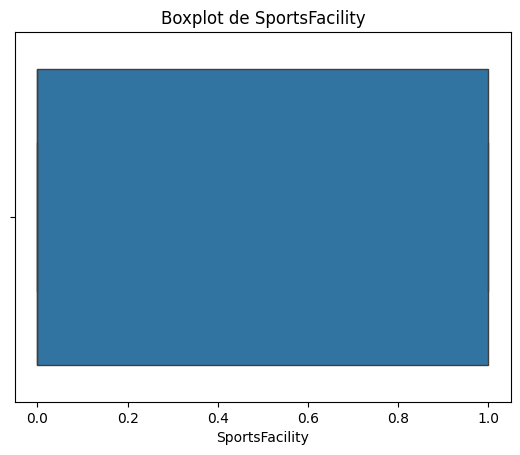

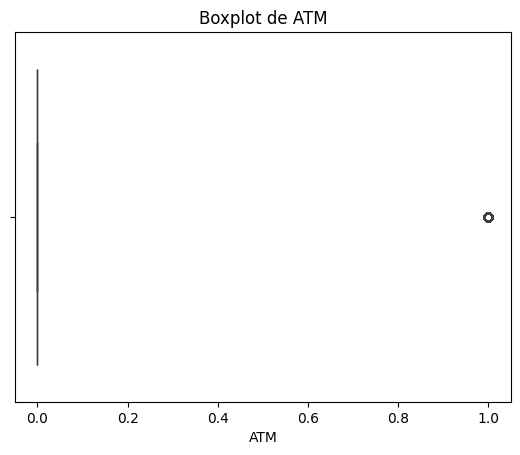

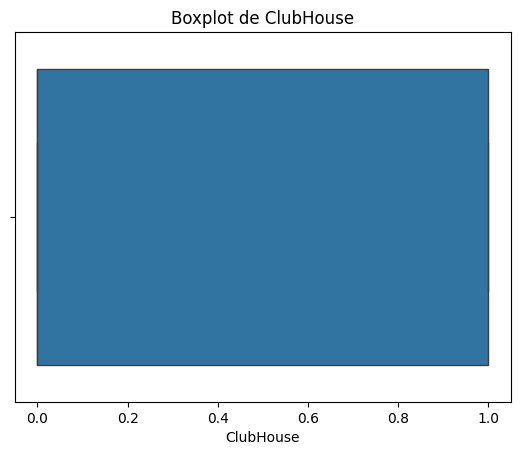

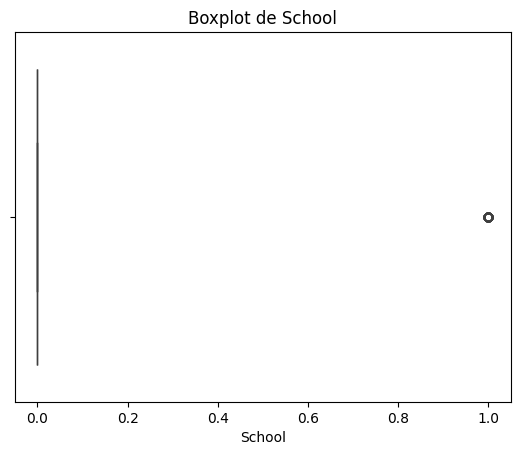

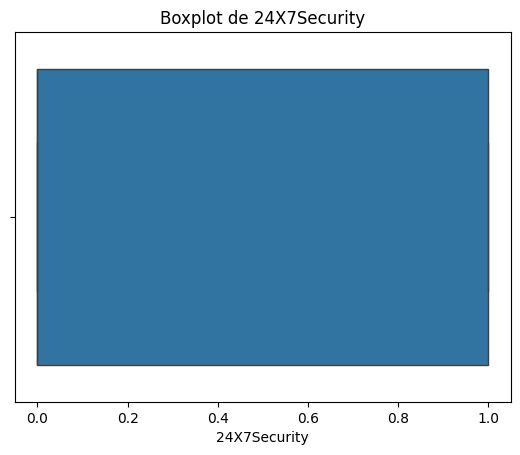

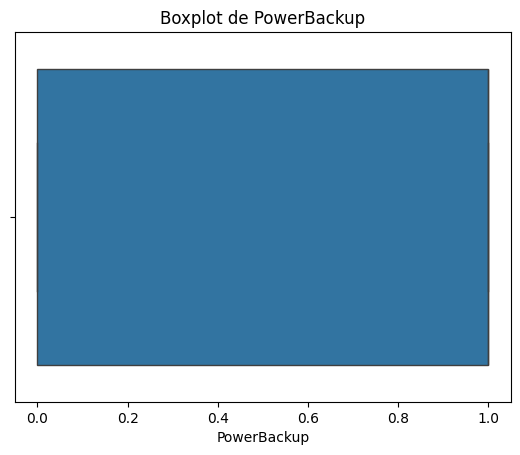

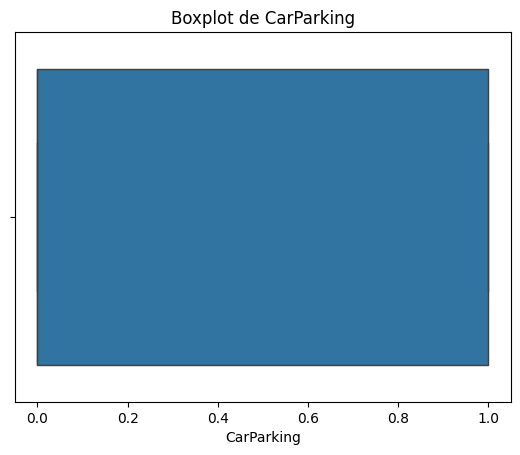

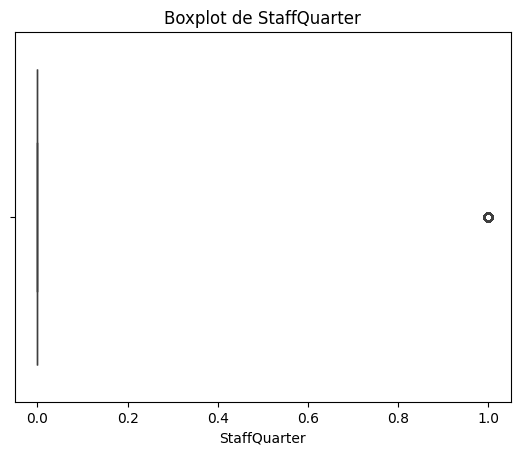

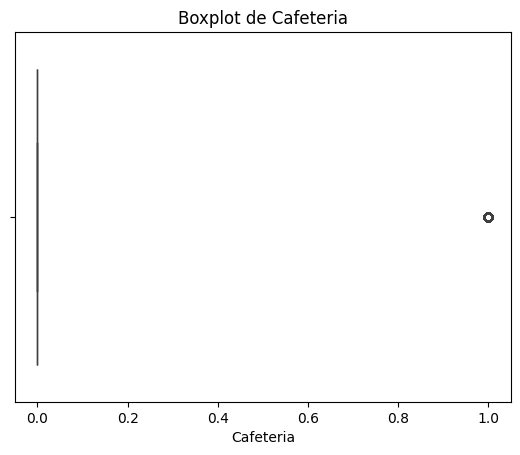

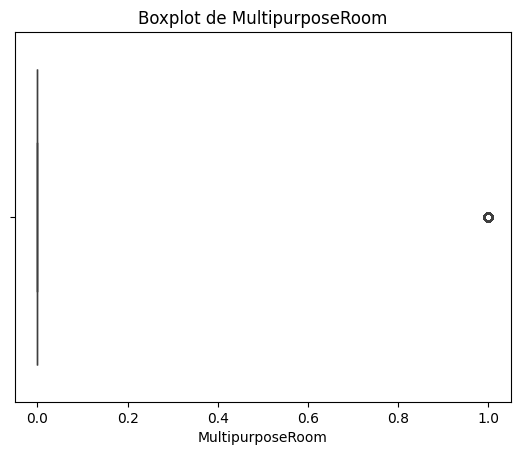

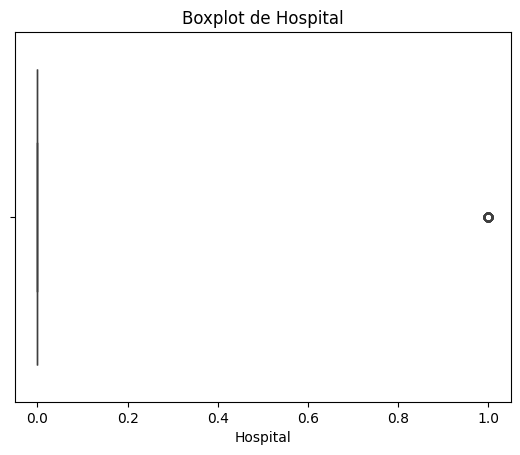

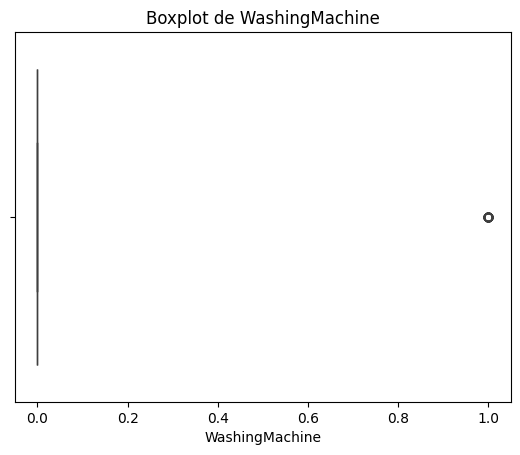

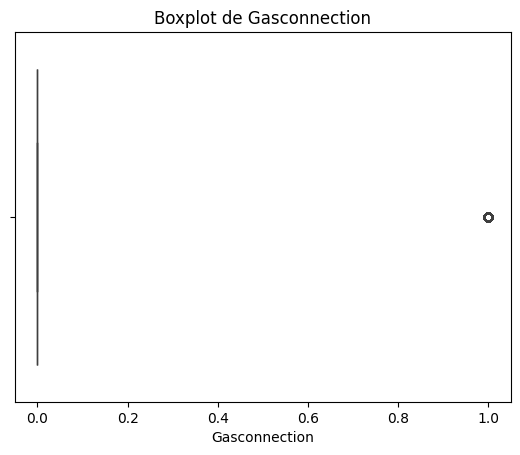

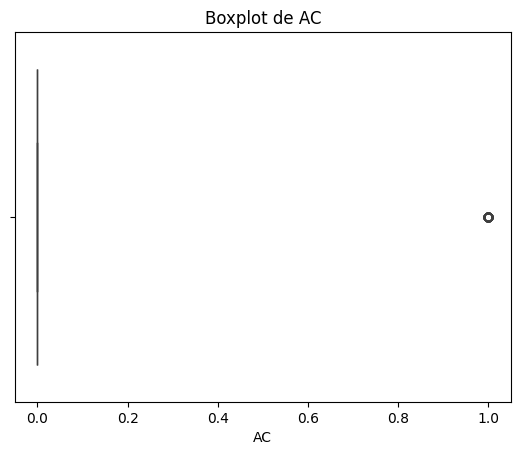

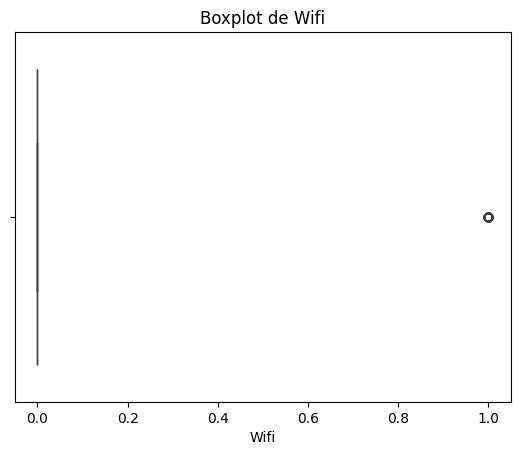

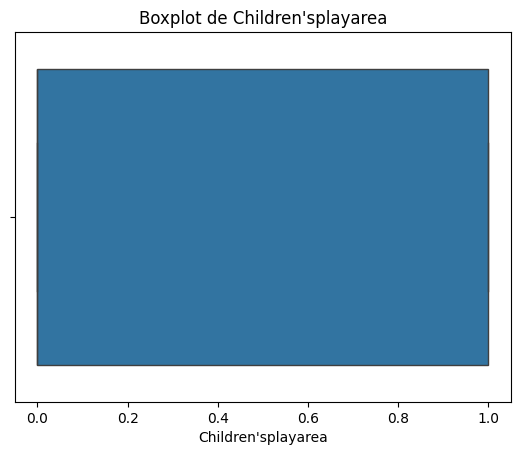

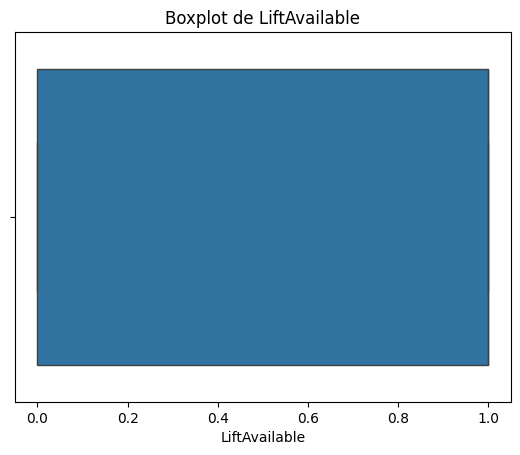

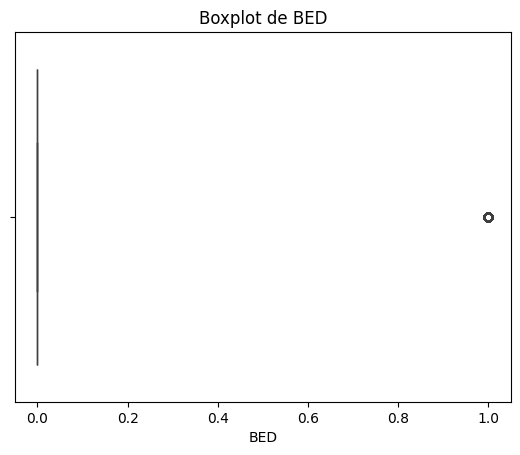

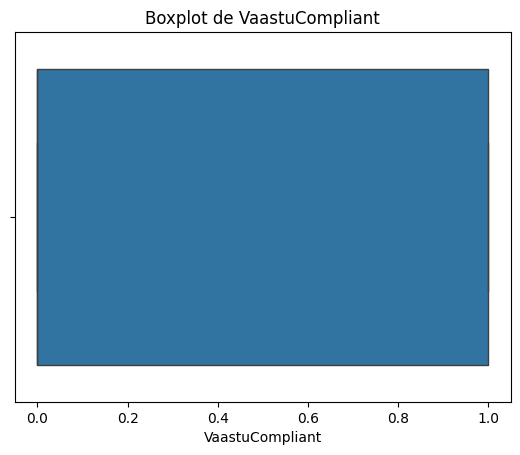

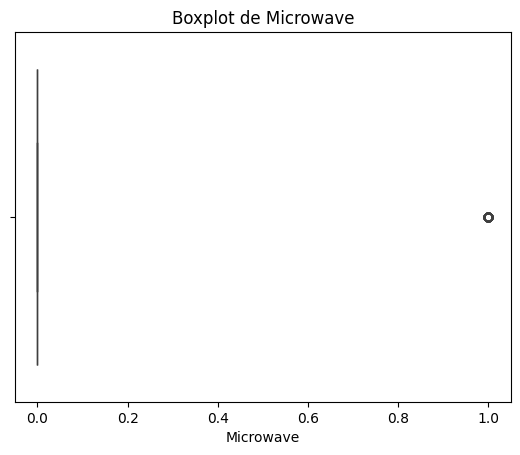

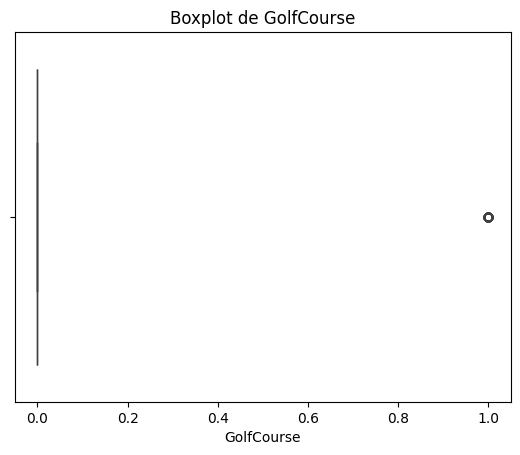

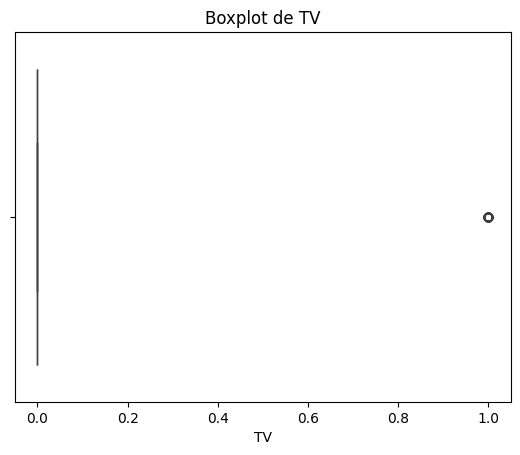

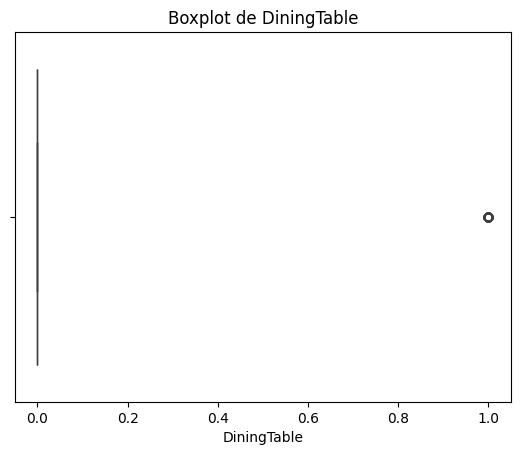

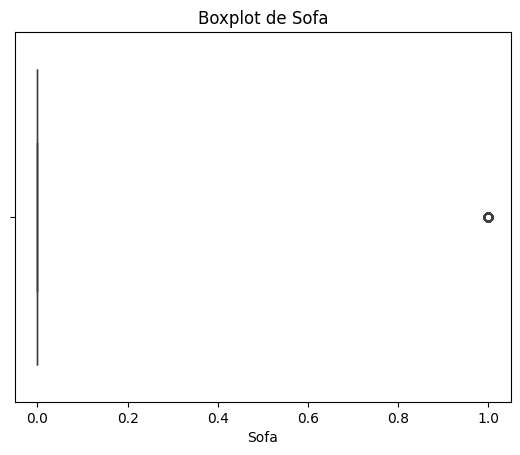

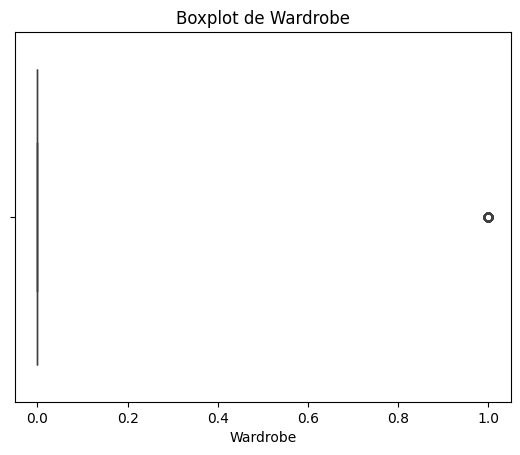

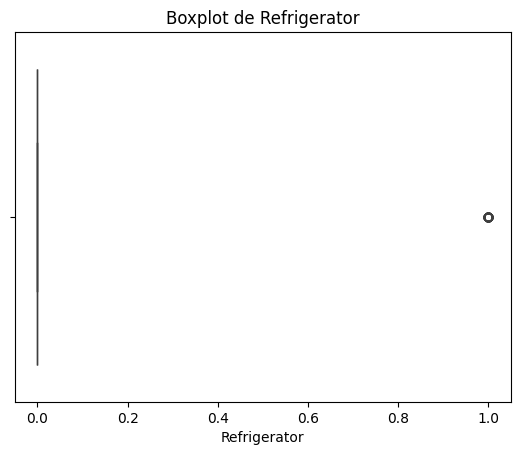

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


for col in binary_cols:
    sns.boxplot(x=binary_impute[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

## 4.0 Checking multicollinearity

# 4.1 Variance Inflation Factor

# VIF = 1 → No colinealidad.
# VIF entre 1 y 5 → Aceptable.
# VIF > 10 → Problema serio de multicolinealidad.

In [ ]:
# Variance Inflation Factor

# VIF = 1 → No colinealidad.
# VIF entre 1 y 5 → Aceptable.
# VIF > 10 → Problema serio de multicolinealidad.

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

df = processed_ds.copy()    

# Selecciona solo las variables numéricas relevantes (sin la target)
X = df.select_dtypes(include=["int64", "float64"]).drop(columns=[LOCATION, PRICE], errors="ignore")

# Calcular VIF para cada columna
# VIF = 1: No multicollinearity.
# VIF between 1 and 5: Moderate multicollinearity.
# VIF > 5 or 10: High multicollinearity (depending on the analyst's criteria).
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]



print(vif_data)

                feature         VIF
0                  Area   16.325049
1       No. of Bedrooms   17.890556
2                Resale    1.610794
3      MaintenanceStaff   46.734053
4             Gymnasium   95.928016
5          SwimmingPool   85.415010
6     LandscapedGardens   60.975174
7          JoggingTrack   66.629462
8   RainWaterHarvesting   51.606343
9           IndoorGames   62.120621
10         ShoppingMall  118.717635
11             Intercom   34.518735
12       SportsFacility   43.306485
13                  ATM   63.624888
14            ClubHouse   79.699809
15               School  311.005104
16         24X7Security   40.085396
17          PowerBackup   46.315131
18           CarParking   48.995710
19         StaffQuarter   60.484178
20            Cafeteria   57.055366
21     MultipurposeRoom   47.506063
22             Hospital  330.301384
23       WashingMachine  400.165368
24        Gasconnection   63.972977
25                   AC  162.162391
26                 Wifi  146

## 4.2 Split training, and validation, and test datasets

## 4.2 Fixing Multicollinearity

# Eliminate redundant variables (such as X2 if it is derived from X1).
# Combine correlated variables (for example, using PCA).
# Apply regularization (Ridge or Lasso).
# Review the model structure and consider transformations.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Función de regresión lineal
def lineal_regresion_model_apply(x_train, y_train, x_val, y_val):
    model = LinearRegression()
    model.fit(x_train, y_train)
    predicts = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, predicts))
    r2 = r2_score(y_val, predicts)
    return rmse, r2

# Aplicación de PCA y regresión
def pca_model_apply(x_train, y_train, x_val, y_val, n):
    pca_model = PCA(n_components=n)
    x_train_pca = pca_model.fit_transform(x_train)
    x_val_pca = pca_model.transform(x_val)
    rmse, r2 = lineal_regresion_model_apply(x_train_pca, y_train, x_val_pca, y_val)
    return rmse, r2, pca_model

# Selección del mejor modelo PCA usando score balanceado
def find_best_pca_model(x_train, y_train, x_val, y_val, rmse_baseline, alpha=1.0, beta=1.0):
    best_score = float("inf")
    best_n = None
    best_pca_model = None
    best_rmse = None
    best_r2 = None
    max_components = x_train.shape[1]

    for n in range(1, max_components + 1):
        rmse, r2, pca_model = pca_model_apply(x_train, y_train, x_val, y_val, n)
        r2_distance = abs(1 - r2)
        score = alpha * r2_distance + beta * (rmse / rmse_baseline)
        print(f"PCA {n} - R²: {r2:.4f} - RMSE: {rmse:.4f} - Score: {score:.4f}")
        if score < best_score:
            best_score = score
            best_n = n
            best_pca_model = pca_model
            best_rmse = rmse
            best_r2 = r2

    print(f"\nBest PCA Model: n: {best_n} R²: {best_r2:.4f} RMSE: {best_rmse:.4f} Score: {best_score:.4f}")
    return best_rmse, best_r2, best_pca_model

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = processed_ds.copy()   
y = df[PRICE]
X = df.drop(columns=[PRICE]).select_dtypes(include=["int64", "float64"]).drop(columns=[LOCATION, PRICE], errors="ignore")


# 2. Dividir el dataset en train (60%), validation (20%) y test (20%)
# Primero, separamos train (60%) y temp (40%)
x_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Ahora separamos temp en val (20%) y test (20%)
x_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# StandardScaler standardizes features by removing the mean and scaling to unit variance. The formula for each feature is:
# X_scaled = (X - μ) / σ
# μ = mean of the feature (calculated from the training set)
# σ = standard deviation of the feature (calculated from the training set)
# This transformation ensures that each feature has:
# Mean = 0
# Standard deviation = 1
# It is important for algorithms like PCA because they are sensitive to the scale of the variables.
# StandardScaler standardizes the features by removing the mean and scaling them to unit variance. Specifically, for each feature (column):
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)  # fit SOLO con train
x_val_std   = scaler.transform(x_val)
x_test_std  = scaler.transform(X_test)

# Evaluación del modelo sin PCA
pre_rmse, pre_r2_distance = lineal_regresion_model_apply(x_train_std, y_train, x_val_std, y_val)
print(f"Pre Regresion Model:  R²: {pre_r2_distance} RMSE: {pre_rmse:.4f}")

find_best_pca_model(x_train_std, y_train, x_val, y_val, pre_rmse, 0.7, 1)

Pre Regresion Model:  R²: 0.7866065923321424 RMSE: 3622314.9807
PCA 1 - R²: 0.0058 - RMSE: 7818643.9881 - Score: 2.8544
PCA 2 - R²: -537431.6933 - RMSE: 5748542594.6085 - Score: 377789.8657
PCA 3 - R²: -565054.6506 - RMSE: 5894423338.8499 - Score: 397166.2085
PCA 4 - R²: -575169.4993 - RMSE: 5946946260.8329 - Score: 404261.1025
PCA 5 - R²: -3039905.7932 - RMSE: 13671804720.4766 - Score: 2131709.0832
PCA 6 - R²: -3038304.3583 - RMSE: 13668203065.8143 - Score: 2130587.0845
PCA 7 - R²: -3048581.4528 - RMSE: 13691299959.2321 - Score: 2137787.4269
PCA 8 - R²: -3027713.8696 - RMSE: 13644360941.1991 - Score: 2123167.1604
PCA 9 - R²: -3045788.6811 - RMSE: 13685027300.2335 - Score: 2135830.7550
PCA 10 - R²: -3043485.2264 - RMSE: 13679851499.1386 - Score: 2134216.9079
PCA 11 - R²: -3047336.1847 - RMSE: 13688503400.4734 - Score: 2136914.9672
PCA 12 - R²: -3047323.7376 - RMSE: 13688475444.4892 - Score: 2136906.2465
PCA 13 - R²: -3071851.3734 - RMSE: 13743453675.7948 - Score: 2154090.7692
PCA 14 - 

c:\Users\luis.bolanoss\Documents\Labs\repositories\labs_machine_learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\luis.bolanoss\Documents\Labs\repositories\labs_machine_learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\luis.bolanoss\Documents\Labs\repositories\labs_machine_learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\luis.bolanoss\Documents\Labs\repositories\labs_machine_learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\luis.bolanoss\Documents\Labs\repositories\labs_machine_learning\.venv\Lib\site-packages\sklearn\uti

(np.float64(7818643.988077583), 0.005805281199341095, PCA(n_components=1))

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes

# Cargar el dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Dividir el dataset en train (60%), validation (20%) y test (20%)
x_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Escalar los datos
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_val_std = scaler.transform(x_val)
x_test_std = scaler.transform(x_test)

# Evaluar modelo sin PCA
pre_rmse, pre_r2 = lineal_regresion_model_apply(x_train_std, y_train, x_val_std, y_val)
print(f"\nModelo sin PCA - R²: {pre_r2:.4f} - RMSE: {pre_rmse:.4f}")

# Buscar mejor modelo PCA
best_rmse, best_r2, best_pca_model = find_best_pca_model(x_train_std, y_train, x_val_std, y_val, rmse_baseline=pre_rmse)





Modelo sin PCA - R²: 0.5810 - RMSE: 49.1497
PCA 1 - R²: 0.2929 - RMSE: 63.8470 - Score: 2.0061
PCA 2 - R²: 0.3435 - RMSE: 61.5189 - Score: 1.9081
PCA 3 - R²: 0.3686 - RMSE: 60.3330 - Score: 1.8590
PCA 4 - R²: 0.5832 - RMSE: 49.0156 - Score: 1.4140
PCA 5 - R²: 0.5837 - RMSE: 48.9917 - Score: 1.4131
PCA 6 - R²: 0.5631 - RMSE: 50.1874 - Score: 1.4580
PCA 7 - R²: 0.5721 - RMSE: 49.6644 - Score: 1.4383
PCA 8 - R²: 0.5757 - RMSE: 49.4572 - Score: 1.4305
PCA 9 - R²: 0.5759 - RMSE: 49.4445 - Score: 1.4301
PCA 10 - R²: 0.5810 - RMSE: 49.1497 - Score: 1.4190

Best PCA Model: n: 5 R²: 0.5837 RMSE: 48.9917 Score: 1.4131


## Export Processed Dataset

Export the processed dataset

In [ ]:
processed_ds.to_csv("../../../datasets/raw/hyderabad_house_price_processed.csv", index=False)